# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=1)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 44026 substitutions for model Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=1)


  0% (    1 of 44026) |            | Elapsed Time: 0:00:03 ETA:  2 days, 0:14:43

  0% (   88 of 44026) |                    | Elapsed Time: 0:00:04 ETA:  0:08:23

  0% (  172 of 44026) |                    | Elapsed Time: 0:00:05 ETA:  0:08:32

  0% (  254 of 44026) |                    | Elapsed Time: 0:00:06 ETA:  0:08:38

  0% (  339 of 44026) |                    | Elapsed Time: 0:00:07 ETA:  0:08:35

  0% (  420 of 44026) |                    | Elapsed Time: 0:00:08 ETA:  0:08:39

  1% (  507 of 44026) |                    | Elapsed Time: 0:00:09 ETA:  0:08:34

  1% (  551 of 44026) |                    | Elapsed Time: 0:00:10 ETA:  0:08:35

  1% (  636 of 44026) |                    | Elapsed Time: 0:00:11 ETA:  0:08:34

  1% (  720 of 44026) |                    | Elapsed Time: 0:00:12 ETA:  0:08:33

  1% (  800 of 44026) |                    | Elapsed Time: 0:00:13 ETA:  0:08:49

  2% (  884 of 44026) |                    | Elapsed Time: 0:00:14 ETA:  0:08:48

  2% (  970 of 44026) |                    | Elapsed Time: 0:00:15 ETA:  0:08:44

  2% ( 1059 of 44026) |                    | Elapsed Time: 0:00:16 ETA:  0:08:40

  2% ( 1101 of 44026) |                    | Elapsed Time: 0:00:17 ETA:  0:08:37

  2% ( 1187 of 44026) |                    | Elapsed Time: 0:00:18 ETA:  0:08:36

  2% ( 1277 of 44026) |                    | Elapsed Time: 0:00:19 ETA:  0:08:29

  3% ( 1367 of 44026) |                    | Elapsed Time: 0:00:20 ETA:  0:08:24

  3% ( 1460 of 44026) |                    | Elapsed Time: 0:00:21 ETA:  0:08:17

  3% ( 1541 of 44026) |                    | Elapsed Time: 0:00:22 ETA:  0:08:04

  3% ( 1623 of 44026) |                    | Elapsed Time: 0:00:23 ETA:  0:08:04

  3% ( 1651 of 44026) |                    | Elapsed Time: 0:00:23 ETA:  0:08:05

  3% ( 1729 of 44026) |                    | Elapsed Time: 0:00:24 ETA:  0:08:13

  4% ( 1810 of 44026) |                    | Elapsed Time: 0:00:25 ETA:  0:08:15

  4% ( 1890 of 44026) |                    | Elapsed Time: 0:00:26 ETA:  0:08:19

  4% ( 1960 of 44026) |                    | Elapsed Time: 0:00:27 ETA:  0:08:33

  4% ( 2024 of 44026) |                    | Elapsed Time: 0:00:28 ETA:  0:08:54

  4% ( 2094 of 44026) |                    | Elapsed Time: 0:00:29 ETA:  0:09:14

  4% ( 2160 of 44026) |                    | Elapsed Time: 0:00:30 ETA:  0:09:27

  5% ( 2202 of 44026) |#                   | Elapsed Time: 0:00:31 ETA:  0:09:42

  5% ( 2277 of 44026) |#                   | Elapsed Time: 0:00:32 ETA:  0:09:40

  5% ( 2356 of 44026) |#                   | Elapsed Time: 0:00:33 ETA:  0:09:38

  5% ( 2435 of 44026) |#                   | Elapsed Time: 0:00:34 ETA:  0:09:40

  5% ( 2515 of 44026) |#                   | Elapsed Time: 0:00:35 ETA:  0:09:39

  5% ( 2593 of 44026) |#                   | Elapsed Time: 0:00:36 ETA:  0:09:31

  6% ( 2672 of 44026) |#                   | Elapsed Time: 0:00:37 ETA:  0:09:16

  6% ( 2752 of 44026) |#                   | Elapsed Time: 0:00:38 ETA:  0:08:58

  6% ( 2833 of 44026) |#                   | Elapsed Time: 0:00:39 ETA:  0:08:44

  6% ( 2889 of 44026) |#                   | Elapsed Time: 0:00:40 ETA:  0:09:01

  6% ( 2966 of 44026) |#                   | Elapsed Time: 0:00:41 ETA:  0:09:01

  6% ( 3047 of 44026) |#                   | Elapsed Time: 0:00:42 ETA:  0:08:57

  7% ( 3126 of 44026) |#                   | Elapsed Time: 0:00:43 ETA:  0:08:57

  7% ( 3207 of 44026) |#                   | Elapsed Time: 0:00:44 ETA:  0:08:53

  7% ( 3302 of 44026) |#                   | Elapsed Time: 0:00:45 ETA:  0:08:50

  7% ( 3381 of 44026) |#                   | Elapsed Time: 0:00:46 ETA:  0:08:47

  7% ( 3464 of 44026) |#                   | Elapsed Time: 0:00:47 ETA:  0:08:44

  8% ( 3548 of 44026) |#                   | Elapsed Time: 0:00:48 ETA:  0:08:19

  8% ( 3629 of 44026) |#                   | Elapsed Time: 0:00:49 ETA:  0:08:15

  8% ( 3715 of 44026) |#                   | Elapsed Time: 0:00:50 ETA:  0:08:10

  8% ( 3786 of 44026) |#                   | Elapsed Time: 0:00:51 ETA:  0:08:16

  8% ( 3853 of 44026) |#                   | Elapsed Time: 0:00:52 ETA:  0:08:40

  8% ( 3913 of 44026) |#                   | Elapsed Time: 0:00:53 ETA:  0:08:57

  9% ( 3969 of 44026) |#                   | Elapsed Time: 0:00:54 ETA:  0:09:19

  9% ( 4029 of 44026) |#                   | Elapsed Time: 0:00:55 ETA:  0:09:44

  9% ( 4086 of 44026) |#                   | Elapsed Time: 0:00:56 ETA:  0:10:16

  9% ( 4151 of 44026) |#                   | Elapsed Time: 0:00:57 ETA:  0:10:35

  9% ( 4215 of 44026) |#                   | Elapsed Time: 0:00:58 ETA:  0:11:05

  9% ( 4284 of 44026) |#                   | Elapsed Time: 0:00:59 ETA:  0:11:07

  9% ( 4353 of 44026) |#                   | Elapsed Time: 0:01:00 ETA:  0:10:49

 10% ( 4403 of 44026) |##                  | Elapsed Time: 0:01:01 ETA:  0:10:33

 10% ( 4491 of 44026) |##                  | Elapsed Time: 0:01:02 ETA:  0:09:58

 10% ( 4575 of 44026) |##                  | Elapsed Time: 0:01:03 ETA:  0:09:27

 10% ( 4650 of 44026) |##                  | Elapsed Time: 0:01:04 ETA:  0:09:10

 10% ( 4717 of 44026) |##                  | Elapsed Time: 0:01:05 ETA:  0:08:59

 10% ( 4805 of 44026) |##                  | Elapsed Time: 0:01:06 ETA:  0:08:36

 11% ( 4895 of 44026) |##                  | Elapsed Time: 0:01:07 ETA:  0:08:13

 11% ( 4953 of 44026) |##                  | Elapsed Time: 0:01:08 ETA:  0:08:01

 11% ( 5036 of 44026) |##                  | Elapsed Time: 0:01:09 ETA:  0:07:49

 11% ( 5119 of 44026) |##                  | Elapsed Time: 0:01:10 ETA:  0:07:47

 11% ( 5203 of 44026) |##                  | Elapsed Time: 0:01:11 ETA:  0:07:49

 12% ( 5287 of 44026) |##                  | Elapsed Time: 0:01:12 ETA:  0:07:48

 12% ( 5371 of 44026) |##                  | Elapsed Time: 0:01:13 ETA:  0:08:05

 12% ( 5453 of 44026) |##                  | Elapsed Time: 0:01:14 ETA:  0:07:53

 12% ( 5504 of 44026) |##                  | Elapsed Time: 0:01:15 ETA:  0:07:56

 12% ( 5589 of 44026) |##                  | Elapsed Time: 0:01:16 ETA:  0:07:59

 12% ( 5673 of 44026) |##                  | Elapsed Time: 0:01:17 ETA:  0:07:57

 13% ( 5758 of 44026) |##                  | Elapsed Time: 0:01:18 ETA:  0:07:54

 13% ( 5843 of 44026) |##                  | Elapsed Time: 0:01:19 ETA:  0:07:52

 13% ( 5928 of 44026) |##                  | Elapsed Time: 0:01:20 ETA:  0:07:50

 13% ( 6012 of 44026) |##                  | Elapsed Time: 0:01:21 ETA:  0:07:49

 13% ( 6054 of 44026) |##                  | Elapsed Time: 0:01:21 ETA:  0:07:23

 13% ( 6138 of 44026) |##                  | Elapsed Time: 0:01:22 ETA:  0:07:21

 14% ( 6224 of 44026) |##                  | Elapsed Time: 0:01:23 ETA:  0:07:19

 14% ( 6307 of 44026) |##                  | Elapsed Time: 0:01:24 ETA:  0:07:19

 14% ( 6391 of 44026) |##                  | Elapsed Time: 0:01:25 ETA:  0:07:18

 14% ( 6477 of 44026) |##                  | Elapsed Time: 0:01:26 ETA:  0:07:16

 14% ( 6560 of 44026) |##                  | Elapsed Time: 0:01:27 ETA:  0:07:16

 15% ( 6604 of 44026) |###                 | Elapsed Time: 0:01:28 ETA:  0:07:15

 15% ( 6689 of 44026) |###                 | Elapsed Time: 0:01:29 ETA:  0:07:13

 15% ( 6773 of 44026) |###                 | Elapsed Time: 0:01:30 ETA:  0:07:13

 15% ( 6860 of 44026) |###                 | Elapsed Time: 0:01:31 ETA:  0:07:09

 15% ( 6954 of 44026) |###                 | Elapsed Time: 0:01:32 ETA:  0:07:03

 15% ( 7041 of 44026) |###                 | Elapsed Time: 0:01:33 ETA:  0:06:59

 16% ( 7125 of 44026) |###                 | Elapsed Time: 0:01:34 ETA:  0:06:58

 16% ( 7155 of 44026) |###                 | Elapsed Time: 0:01:34 ETA:  0:06:58

 16% ( 7239 of 44026) |###                 | Elapsed Time: 0:01:35 ETA:  0:06:57

 16% ( 7323 of 44026) |###                 | Elapsed Time: 0:01:36 ETA:  0:06:57

 16% ( 7408 of 44026) |###                 | Elapsed Time: 0:01:37 ETA:  0:06:57

 17% ( 7492 of 44026) |###                 | Elapsed Time: 0:01:38 ETA:  0:06:56

 17% ( 7576 of 44026) |###                 | Elapsed Time: 0:01:39 ETA:  0:06:57

 17% ( 7664 of 44026) |###                 | Elapsed Time: 0:01:40 ETA:  0:07:00

 17% ( 7705 of 44026) |###                 | Elapsed Time: 0:01:41 ETA:  0:07:02

 17% ( 7792 of 44026) |###                 | Elapsed Time: 0:01:42 ETA:  0:06:59

 17% ( 7878 of 44026) |###                 | Elapsed Time: 0:01:43 ETA:  0:06:57

 18% ( 7965 of 44026) |###                 | Elapsed Time: 0:01:44 ETA:  0:06:53

 18% ( 8051 of 44026) |###                 | Elapsed Time: 0:01:45 ETA:  0:06:50

 18% ( 8137 of 44026) |###                 | Elapsed Time: 0:01:46 ETA:  0:06:48

 18% ( 8225 of 44026) |###                 | Elapsed Time: 0:01:47 ETA:  0:06:45

 18% ( 8255 of 44026) |###                 | Elapsed Time: 0:01:47 ETA:  0:06:43

 18% ( 8340 of 44026) |###                 | Elapsed Time: 0:01:48 ETA:  0:06:44

 19% ( 8423 of 44026) |###                 | Elapsed Time: 0:01:49 ETA:  0:06:44

 19% ( 8509 of 44026) |###                 | Elapsed Time: 0:01:50 ETA:  0:06:44

 19% ( 8594 of 44026) |###                 | Elapsed Time: 0:01:51 ETA:  0:06:43

 19% ( 8680 of 44026) |###                 | Elapsed Time: 0:01:52 ETA:  0:06:43

 19% ( 8760 of 44026) |###                 | Elapsed Time: 0:01:54 ETA:  0:07:12

 20% ( 8806 of 44026) |####                | Elapsed Time: 0:01:54 ETA:  0:07:16

 20% ( 8888 of 44026) |####                | Elapsed Time: 0:01:55 ETA:  0:07:20

 20% ( 8974 of 44026) |####                | Elapsed Time: 0:01:56 ETA:  0:07:16

 20% ( 9059 of 44026) |####                | Elapsed Time: 0:01:57 ETA:  0:07:14

 20% ( 9145 of 44026) |####                | Elapsed Time: 0:01:58 ETA:  0:07:11

 20% ( 9231 of 44026) |####                | Elapsed Time: 0:01:59 ETA:  0:07:10

 21% ( 9317 of 44026) |####                | Elapsed Time: 0:02:00 ETA:  0:07:09

 21% ( 9356 of 44026) |####                | Elapsed Time: 0:02:01 ETA:  0:07:11

 21% ( 9442 of 44026) |####                | Elapsed Time: 0:02:02 ETA:  0:06:39

 21% ( 9526 of 44026) |####                | Elapsed Time: 0:02:03 ETA:  0:06:36

 21% ( 9612 of 44026) |####                | Elapsed Time: 0:02:04 ETA:  0:06:32

 22% ( 9698 of 44026) |####                | Elapsed Time: 0:02:05 ETA:  0:06:31

 22% ( 9784 of 44026) |####                | Elapsed Time: 0:02:06 ETA:  0:06:29

 22% ( 9870 of 44026) |####                | Elapsed Time: 0:02:07 ETA:  0:06:28

 22% ( 9906 of 44026) |####                | Elapsed Time: 0:02:07 ETA:  0:06:28

 22% ( 9993 of 44026) |####                | Elapsed Time: 0:02:08 ETA:  0:06:27

 22% (10080 of 44026) |####                | Elapsed Time: 0:02:09 ETA:  0:06:25

 23% (10163 of 44026) |####                | Elapsed Time: 0:02:10 ETA:  0:06:26

 23% (10251 of 44026) |####                | Elapsed Time: 0:02:11 ETA:  0:06:23

 23% (10338 of 44026) |####                | Elapsed Time: 0:02:12 ETA:  0:06:21

 23% (10424 of 44026) |####                | Elapsed Time: 0:02:13 ETA:  0:06:19

 23% (10457 of 44026) |####                | Elapsed Time: 0:02:14 ETA:  0:06:19

 23% (10545 of 44026) |####                | Elapsed Time: 0:02:15 ETA:  0:06:17

 24% (10614 of 44026) |####                | Elapsed Time: 0:02:16 ETA:  0:06:27

 24% (10680 of 44026) |####                | Elapsed Time: 0:02:17 ETA:  0:06:42

 24% (10743 of 44026) |####                | Elapsed Time: 0:02:18 ETA:  0:07:01

 24% (10808 of 44026) |####                | Elapsed Time: 0:02:19 ETA:  0:07:16

 24% (10871 of 44026) |####                | Elapsed Time: 0:02:20 ETA:  0:07:38

 24% (10930 of 44026) |####                | Elapsed Time: 0:02:21 ETA:  0:08:06

 24% (10992 of 44026) |####                | Elapsed Time: 0:02:22 ETA:  0:08:31

 25% (11007 of 44026) |#####               | Elapsed Time: 0:02:22 ETA:  0:08:42

 25% (11075 of 44026) |#####               | Elapsed Time: 0:02:23 ETA:  0:09:06

 25% (11151 of 44026) |#####               | Elapsed Time: 0:02:24 ETA:  0:08:56

 25% (11223 of 44026) |#####               | Elapsed Time: 0:02:25 ETA:  0:08:47

 25% (11295 of 44026) |#####               | Elapsed Time: 0:02:26 ETA:  0:08:35

 25% (11364 of 44026) |#####               | Elapsed Time: 0:02:27 ETA:  0:08:29

 25% (11432 of 44026) |#####               | Elapsed Time: 0:02:28 ETA:  0:08:22

 26% (11514 of 44026) |#####               | Elapsed Time: 0:02:29 ETA:  0:07:55

 26% (11557 of 44026) |#####               | Elapsed Time: 0:02:29 ETA:  0:07:38

 26% (11640 of 44026) |#####               | Elapsed Time: 0:02:30 ETA:  0:07:25

 26% (11722 of 44026) |#####               | Elapsed Time: 0:02:31 ETA:  0:07:11

 26% (11806 of 44026) |#####               | Elapsed Time: 0:02:32 ETA:  0:07:03

 27% (11889 of 44026) |#####               | Elapsed Time: 0:02:33 ETA:  0:06:52

 27% (11973 of 44026) |#####               | Elapsed Time: 0:02:34 ETA:  0:06:41

 27% (12058 of 44026) |#####               | Elapsed Time: 0:02:35 ETA:  0:06:27

 27% (12108 of 44026) |#####               | Elapsed Time: 0:02:36 ETA:  0:06:14

 27% (12192 of 44026) |#####               | Elapsed Time: 0:02:37 ETA:  0:06:12

 27% (12274 of 44026) |#####               | Elapsed Time: 0:02:38 ETA:  0:06:12

 28% (12358 of 44026) |#####               | Elapsed Time: 0:02:39 ETA:  0:06:10

 28% (12443 of 44026) |#####               | Elapsed Time: 0:02:40 ETA:  0:06:07

 28% (12523 of 44026) |#####               | Elapsed Time: 0:02:41 ETA:  0:06:09

 28% (12600 of 44026) |#####               | Elapsed Time: 0:02:42 ETA:  0:06:12

 28% (12658 of 44026) |#####               | Elapsed Time: 0:02:43 ETA:  0:06:17

 28% (12735 of 44026) |#####               | Elapsed Time: 0:02:44 ETA:  0:06:22

 29% (12808 of 44026) |#####               | Elapsed Time: 0:02:45 ETA:  0:07:03

 29% (12885 of 44026) |#####               | Elapsed Time: 0:02:46 ETA:  0:07:08

 29% (12961 of 44026) |#####               | Elapsed Time: 0:02:47 ETA:  0:07:12

 29% (13034 of 44026) |#####               | Elapsed Time: 0:02:48 ETA:  0:07:21

 29% (13106 of 44026) |#####               | Elapsed Time: 0:02:49 ETA:  0:07:32

 29% (13180 of 44026) |#####               | Elapsed Time: 0:02:50 ETA:  0:07:37

 30% (13208 of 44026) |######              | Elapsed Time: 0:02:51 ETA:  0:07:46

 30% (13286 of 44026) |######              | Elapsed Time: 0:02:52 ETA:  0:07:41

 30% (13363 of 44026) |######              | Elapsed Time: 0:02:53 ETA:  0:07:40

 30% (13441 of 44026) |######              | Elapsed Time: 0:02:54 ETA:  0:06:56

 30% (13519 of 44026) |######              | Elapsed Time: 0:02:55 ETA:  0:06:54

 30% (13592 of 44026) |######              | Elapsed Time: 0:02:56 ETA:  0:06:56

 31% (13665 of 44026) |######              | Elapsed Time: 0:02:57 ETA:  0:06:55

 31% (13759 of 44026) |######              | Elapsed Time: 0:02:58 ETA:  0:06:32

 31% (13833 of 44026) |######              | Elapsed Time: 0:02:59 ETA:  0:06:30

 31% (13906 of 44026) |######              | Elapsed Time: 0:03:00 ETA:  0:06:28

 31% (13968 of 44026) |######              | Elapsed Time: 0:03:01 ETA:  0:06:41

 31% (14038 of 44026) |######              | Elapsed Time: 0:03:02 ETA:  0:06:46

 32% (14110 of 44026) |######              | Elapsed Time: 0:03:03 ETA:  0:06:50

 32% (14181 of 44026) |######              | Elapsed Time: 0:03:04 ETA:  0:06:55

 32% (14261 of 44026) |######              | Elapsed Time: 0:03:05 ETA:  0:06:48

 32% (14309 of 44026) |######              | Elapsed Time: 0:03:06 ETA:  0:06:40

 32% (14396 of 44026) |######              | Elapsed Time: 0:03:07 ETA:  0:06:48

 32% (14479 of 44026) |######              | Elapsed Time: 0:03:08 ETA:  0:06:39

 33% (14552 of 44026) |######              | Elapsed Time: 0:03:09 ETA:  0:06:38

 33% (14636 of 44026) |######              | Elapsed Time: 0:03:10 ETA:  0:06:18

 33% (14722 of 44026) |######              | Elapsed Time: 0:03:11 ETA:  0:06:03

 33% (14810 of 44026) |######              | Elapsed Time: 0:03:12 ETA:  0:05:50

 33% (14859 of 44026) |######              | Elapsed Time: 0:03:12 ETA:  0:05:41

 33% (14937 of 44026) |######              | Elapsed Time: 0:03:13 ETA:  0:05:42

 34% (15027 of 44026) |######              | Elapsed Time: 0:03:14 ETA:  0:05:36

 34% (15102 of 44026) |######              | Elapsed Time: 0:03:15 ETA:  0:05:45

 34% (15173 of 44026) |######              | Elapsed Time: 0:03:16 ETA:  0:05:53

 34% (15250 of 44026) |######              | Elapsed Time: 0:03:17 ETA:  0:05:49

 34% (15324 of 44026) |######              | Elapsed Time: 0:03:18 ETA:  0:05:56

 35% (15410 of 44026) |#######             | Elapsed Time: 0:03:19 ETA:  0:06:12

 35% (15491 of 44026) |#######             | Elapsed Time: 0:03:20 ETA:  0:06:10

 35% (15580 of 44026) |#######             | Elapsed Time: 0:03:21 ETA:  0:05:59

 35% (15651 of 44026) |#######             | Elapsed Time: 0:03:22 ETA:  0:06:14

 35% (15726 of 44026) |#######             | Elapsed Time: 0:03:23 ETA:  0:06:13

 35% (15800 of 44026) |#######             | Elapsed Time: 0:03:24 ETA:  0:06:09

 36% (15877 of 44026) |#######             | Elapsed Time: 0:03:25 ETA:  0:06:08

 36% (15960 of 44026) |#######             | Elapsed Time: 0:03:27 ETA:  0:06:05

 36% (16046 of 44026) |#######             | Elapsed Time: 0:03:28 ETA:  0:05:55

 36% (16132 of 44026) |#######             | Elapsed Time: 0:03:29 ETA:  0:05:50

 36% (16223 of 44026) |#######             | Elapsed Time: 0:03:30 ETA:  0:05:47

 37% (16313 of 44026) |#######             | Elapsed Time: 0:03:31 ETA:  0:05:30

 37% (16411 of 44026) |#######             | Elapsed Time: 0:03:32 ETA:  0:05:11

 37% (16510 of 44026) |#######             | Elapsed Time: 0:03:33 ETA:  0:04:49

 37% (16587 of 44026) |#######             | Elapsed Time: 0:03:34 ETA:  0:04:47

 37% (16638 of 44026) |#######             | Elapsed Time: 0:03:35 ETA:  0:05:15

 37% (16697 of 44026) |#######             | Elapsed Time: 0:03:36 ETA:  0:05:36

 38% (16768 of 44026) |#######             | Elapsed Time: 0:03:37 ETA:  0:05:48

 38% (16828 of 44026) |#######             | Elapsed Time: 0:03:38 ETA:  0:06:16

 38% (16888 of 44026) |#######             | Elapsed Time: 0:03:39 ETA:  0:06:46

 38% (16947 of 44026) |#######             | Elapsed Time: 0:03:40 ETA:  0:07:29

 38% (17028 of 44026) |#######             | Elapsed Time: 0:03:41 ETA:  0:07:42

 38% (17061 of 44026) |#######             | Elapsed Time: 0:03:41 ETA:  0:07:33

 38% (17147 of 44026) |#######             | Elapsed Time: 0:03:42 ETA:  0:07:20

 39% (17207 of 44026) |#######             | Elapsed Time: 0:03:44 ETA:  0:07:41

 39% (17271 of 44026) |#######             | Elapsed Time: 0:03:45 ETA:  0:07:34

 39% (17350 of 44026) |#######             | Elapsed Time: 0:03:46 ETA:  0:07:23

 39% (17409 of 44026) |#######             | Elapsed Time: 0:03:47 ETA:  0:07:23

 39% (17470 of 44026) |#######             | Elapsed Time: 0:03:48 ETA:  0:07:20

 39% (17550 of 44026) |#######             | Elapsed Time: 0:03:49 ETA:  0:06:57

 40% (17611 of 44026) |########            | Elapsed Time: 0:03:49 ETA:  0:06:56

 40% (17687 of 44026) |########            | Elapsed Time: 0:03:50 ETA:  0:06:55

 40% (17770 of 44026) |########            | Elapsed Time: 0:03:51 ETA:  0:06:57

 40% (17853 of 44026) |########            | Elapsed Time: 0:03:52 ETA:  0:06:04

 40% (17920 of 44026) |########            | Elapsed Time: 0:03:53 ETA:  0:06:00

 40% (17993 of 44026) |########            | Elapsed Time: 0:03:54 ETA:  0:06:05

 41% (18052 of 44026) |########            | Elapsed Time: 0:03:55 ETA:  0:06:03

 41% (18112 of 44026) |########            | Elapsed Time: 0:03:56 ETA:  0:06:04

 41% (18161 of 44026) |########            | Elapsed Time: 0:03:57 ETA:  0:06:20

 41% (18224 of 44026) |########            | Elapsed Time: 0:03:58 ETA:  0:06:38

 41% (18310 of 44026) |########            | Elapsed Time: 0:03:59 ETA:  0:06:27

 41% (18408 of 44026) |########            | Elapsed Time: 0:04:00 ETA:  0:06:11

 42% (18492 of 44026) |########            | Elapsed Time: 0:04:01 ETA:  0:06:09

 42% (18584 of 44026) |########            | Elapsed Time: 0:04:02 ETA:  0:05:45

 42% (18664 of 44026) |########            | Elapsed Time: 0:04:03 ETA:  0:05:38

 42% (18712 of 44026) |########            | Elapsed Time: 0:04:04 ETA:  0:05:18

 42% (18797 of 44026) |########            | Elapsed Time: 0:04:05 ETA:  0:04:57

 42% (18879 of 44026) |########            | Elapsed Time: 0:04:06 ETA:  0:04:42

 43% (18963 of 44026) |########            | Elapsed Time: 0:04:07 ETA:  0:04:27

 43% (19046 of 44026) |########            | Elapsed Time: 0:04:08 ETA:  0:04:28

 43% (19130 of 44026) |########            | Elapsed Time: 0:04:09 ETA:  0:04:36

 43% (19216 of 44026) |########            | Elapsed Time: 0:04:10 ETA:  0:04:35

 43% (19262 of 44026) |########            | Elapsed Time: 0:04:10 ETA:  0:04:40

 43% (19346 of 44026) |########            | Elapsed Time: 0:04:11 ETA:  0:04:36

 44% (19416 of 44026) |########            | Elapsed Time: 0:04:12 ETA:  0:04:45

 44% (19485 of 44026) |########            | Elapsed Time: 0:04:13 ETA:  0:04:56

 44% (19572 of 44026) |########            | Elapsed Time: 0:04:14 ETA:  0:04:52

 44% (19657 of 44026) |########            | Elapsed Time: 0:04:15 ETA:  0:04:50

 44% (19725 of 44026) |########            | Elapsed Time: 0:04:16 ETA:  0:05:01

 45% (19812 of 44026) |#########           | Elapsed Time: 0:04:18 ETA:  0:05:14

 45% (19892 of 44026) |#########           | Elapsed Time: 0:04:19 ETA:  0:05:13

 45% (19975 of 44026) |#########           | Elapsed Time: 0:04:20 ETA:  0:05:14

 45% (20047 of 44026) |#########           | Elapsed Time: 0:04:21 ETA:  0:05:11

 45% (20121 of 44026) |#########           | Elapsed Time: 0:04:22 ETA:  0:05:05

 45% (20194 of 44026) |#########           | Elapsed Time: 0:04:23 ETA:  0:05:17

 46% (20268 of 44026) |#########           | Elapsed Time: 0:04:24 ETA:  0:05:26

 46% (20341 of 44026) |#########           | Elapsed Time: 0:04:25 ETA:  0:05:20

 46% (20363 of 44026) |#########           | Elapsed Time: 0:04:25 ETA:  0:05:19

 46% (20459 of 44026) |#########           | Elapsed Time: 0:04:26 ETA:  0:05:01

 46% (20593 of 44026) |#########           | Elapsed Time: 0:04:27 ETA:  0:04:16

 47% (20708 of 44026) |#########           | Elapsed Time: 0:04:28 ETA:  0:03:52

 47% (20791 of 44026) |#########           | Elapsed Time: 0:04:29 ETA:  0:03:44

 47% (20844 of 44026) |#########           | Elapsed Time: 0:04:30 ETA:  0:03:57

 47% (20913 of 44026) |#########           | Elapsed Time: 0:04:31 ETA:  0:03:51

 47% (20983 of 44026) |#########           | Elapsed Time: 0:04:32 ETA:  0:03:52

 47% (21051 of 44026) |#########           | Elapsed Time: 0:04:33 ETA:  0:04:02

 47% (21125 of 44026) |#########           | Elapsed Time: 0:04:34 ETA:  0:04:18

 48% (21217 of 44026) |#########           | Elapsed Time: 0:04:35 ETA:  0:04:53

 48% (21305 of 44026) |#########           | Elapsed Time: 0:04:36 ETA:  0:05:17

 48% (21408 of 44026) |#########           | Elapsed Time: 0:04:37 ETA:  0:04:57

 48% (21463 of 44026) |#########           | Elapsed Time: 0:04:38 ETA:  0:04:21

 48% (21562 of 44026) |#########           | Elapsed Time: 0:04:39 ETA:  0:03:54

 49% (21641 of 44026) |#########           | Elapsed Time: 0:04:40 ETA:  0:03:58

 49% (21716 of 44026) |#########           | Elapsed Time: 0:04:41 ETA:  0:03:53

 49% (21795 of 44026) |#########           | Elapsed Time: 0:04:42 ETA:  0:03:44

 49% (21877 of 44026) |#########           | Elapsed Time: 0:04:43 ETA:  0:03:38

 49% (21956 of 44026) |#########           | Elapsed Time: 0:04:44 ETA:  0:03:46

 50% (22014 of 44026) |##########          | Elapsed Time: 0:04:44 ETA:  0:03:46

 50% (22104 of 44026) |##########          | Elapsed Time: 0:04:45 ETA:  0:03:54

 50% (22192 of 44026) |##########          | Elapsed Time: 0:04:46 ETA:  0:03:58

 50% (22271 of 44026) |##########          | Elapsed Time: 0:04:47 ETA:  0:04:12

 50% (22334 of 44026) |##########          | Elapsed Time: 0:04:48 ETA:  0:04:23

 50% (22414 of 44026) |##########          | Elapsed Time: 0:04:49 ETA:  0:04:19

 51% (22493 of 44026) |##########          | Elapsed Time: 0:04:50 ETA:  0:04:18

 51% (22564 of 44026) |##########          | Elapsed Time: 0:04:51 ETA:  0:04:15

 51% (22651 of 44026) |##########          | Elapsed Time: 0:04:52 ETA:  0:04:08

 51% (22673 of 44026) |##########          | Elapsed Time: 0:04:53 ETA:  0:05:10

 51% (22755 of 44026) |##########          | Elapsed Time: 0:04:54 ETA:  0:05:17

 51% (22834 of 44026) |##########          | Elapsed Time: 0:04:55 ETA:  0:05:25

 52% (22900 of 44026) |##########          | Elapsed Time: 0:04:56 ETA:  0:05:37

 52% (22965 of 44026) |##########          | Elapsed Time: 0:04:57 ETA:  0:05:34

 52% (23045 of 44026) |##########          | Elapsed Time: 0:04:58 ETA:  0:05:33

 52% (23114 of 44026) |##########          | Elapsed Time: 0:04:59 ETA:  0:05:29

 52% (23196 of 44026) |##########          | Elapsed Time: 0:05:00 ETA:  0:05:29

 52% (23277 of 44026) |##########          | Elapsed Time: 0:05:01 ETA:  0:05:33

 53% (23349 of 44026) |##########          | Elapsed Time: 0:05:02 ETA:  0:04:35

 53% (23421 of 44026) |##########          | Elapsed Time: 0:05:03 ETA:  0:04:42

 53% (23504 of 44026) |##########          | Elapsed Time: 0:05:04 ETA:  0:04:38

 53% (23589 of 44026) |##########          | Elapsed Time: 0:05:05 ETA:  0:04:21

 53% (23664 of 44026) |##########          | Elapsed Time: 0:05:06 ETA:  0:04:03

 53% (23750 of 44026) |##########          | Elapsed Time: 0:05:07 ETA:  0:03:57

 54% (23835 of 44026) |##########          | Elapsed Time: 0:05:08 ETA:  0:03:56

 54% (23923 of 44026) |##########          | Elapsed Time: 0:05:09 ETA:  0:03:50

 54% (24007 of 44026) |##########          | Elapsed Time: 0:05:10 ETA:  0:03:47

 54% (24091 of 44026) |##########          | Elapsed Time: 0:05:11 ETA:  0:03:37

 54% (24191 of 44026) |##########          | Elapsed Time: 0:05:12 ETA:  0:03:17

 55% (24215 of 44026) |###########         | Elapsed Time: 0:05:12 ETA:  0:03:12

 55% (24298 of 44026) |###########         | Elapsed Time: 0:05:13 ETA:  0:03:12

 55% (24348 of 44026) |###########         | Elapsed Time: 0:05:14 ETA:  0:03:39

 55% (24397 of 44026) |###########         | Elapsed Time: 0:05:15 ETA:  0:04:10

 55% (24461 of 44026) |###########         | Elapsed Time: 0:05:16 ETA:  0:04:28

 55% (24538 of 44026) |###########         | Elapsed Time: 0:05:17 ETA:  0:04:37

 55% (24608 of 44026) |###########         | Elapsed Time: 0:05:18 ETA:  0:04:50

 55% (24652 of 44026) |###########         | Elapsed Time: 0:05:19 ETA:  0:05:33

 56% (24689 of 44026) |###########         | Elapsed Time: 0:05:20 ETA:  0:06:54

 56% (24732 of 44026) |###########         | Elapsed Time: 0:05:21 ETA:  0:07:32

 56% (24765 of 44026) |###########         | Elapsed Time: 0:05:22 ETA:  0:08:14

 56% (24846 of 44026) |###########         | Elapsed Time: 0:05:23 ETA:  0:07:21

 56% (24938 of 44026) |###########         | Elapsed Time: 0:05:24 ETA:  0:06:19

 56% (24994 of 44026) |###########         | Elapsed Time: 0:05:25 ETA:  0:06:28

 56% (25051 of 44026) |###########         | Elapsed Time: 0:05:26 ETA:  0:06:54

 57% (25107 of 44026) |###########         | Elapsed Time: 0:05:27 ETA:  0:07:15

 57% (25182 of 44026) |###########         | Elapsed Time: 0:05:28 ETA:  0:06:29

 57% (25261 of 44026) |###########         | Elapsed Time: 0:05:29 ETA:  0:05:36

 57% (25315 of 44026) |###########         | Elapsed Time: 0:05:30 ETA:  0:04:59

 57% (25395 of 44026) |###########         | Elapsed Time: 0:05:31 ETA:  0:04:40

 57% (25472 of 44026) |###########         | Elapsed Time: 0:05:32 ETA:  0:04:44

 58% (25549 of 44026) |###########         | Elapsed Time: 0:05:33 ETA:  0:04:58

 58% (25622 of 44026) |###########         | Elapsed Time: 0:05:34 ETA:  0:04:39

 58% (25712 of 44026) |###########         | Elapsed Time: 0:05:35 ETA:  0:04:07

 58% (25808 of 44026) |###########         | Elapsed Time: 0:05:36 ETA:  0:03:32

 58% (25866 of 44026) |###########         | Elapsed Time: 0:05:36 ETA:  0:03:21

 58% (25957 of 44026) |###########         | Elapsed Time: 0:05:37 ETA:  0:03:10

 59% (26047 of 44026) |###########         | Elapsed Time: 0:05:38 ETA:  0:03:02

 59% (26134 of 44026) |###########         | Elapsed Time: 0:05:39 ETA:  0:02:56

 59% (26223 of 44026) |###########         | Elapsed Time: 0:05:40 ETA:  0:02:47

 59% (26313 of 44026) |###########         | Elapsed Time: 0:05:41 ETA:  0:02:37

 60% (26416 of 44026) |############        | Elapsed Time: 0:05:42 ETA:  0:02:22

 60% (26486 of 44026) |############        | Elapsed Time: 0:05:44 ETA:  0:02:39

 60% (26565 of 44026) |############        | Elapsed Time: 0:05:45 ETA:  0:02:47

 60% (26658 of 44026) |############        | Elapsed Time: 0:05:46 ETA:  0:02:45

 60% (26738 of 44026) |############        | Elapsed Time: 0:05:47 ETA:  0:02:52

 60% (26825 of 44026) |############        | Elapsed Time: 0:05:48 ETA:  0:02:51

 61% (26910 of 44026) |############        | Elapsed Time: 0:05:49 ETA:  0:02:53

 61% (26966 of 44026) |############        | Elapsed Time: 0:05:49 ETA:  0:02:54

 61% (27030 of 44026) |############        | Elapsed Time: 0:05:50 ETA:  0:03:19

 61% (27105 of 44026) |############        | Elapsed Time: 0:05:51 ETA:  0:03:24

 61% (27193 of 44026) |############        | Elapsed Time: 0:05:52 ETA:  0:03:09

 61% (27262 of 44026) |############        | Elapsed Time: 0:05:53 ETA:  0:03:16

 62% (27355 of 44026) |############        | Elapsed Time: 0:05:54 ETA:  0:03:15

 62% (27441 of 44026) |############        | Elapsed Time: 0:05:55 ETA:  0:03:09

 62% (27500 of 44026) |############        | Elapsed Time: 0:05:56 ETA:  0:03:30

 62% (27517 of 44026) |############        | Elapsed Time: 0:05:57 ETA:  0:03:43

 62% (27575 of 44026) |############        | Elapsed Time: 0:05:58 ETA:  0:04:08

 62% (27647 of 44026) |############        | Elapsed Time: 0:05:59 ETA:  0:03:59

 62% (27723 of 44026) |############        | Elapsed Time: 0:06:00 ETA:  0:03:57

 63% (27809 of 44026) |############        | Elapsed Time: 0:06:01 ETA:  0:03:58

 63% (27892 of 44026) |############        | Elapsed Time: 0:06:02 ETA:  0:03:43

 63% (27984 of 44026) |############        | Elapsed Time: 0:06:03 ETA:  0:03:43

 63% (28067 of 44026) |############        | Elapsed Time: 0:06:04 ETA:  0:03:35

 63% (28147 of 44026) |############        | Elapsed Time: 0:06:05 ETA:  0:03:25

 64% (28228 of 44026) |############        | Elapsed Time: 0:06:06 ETA:  0:03:03

 64% (28311 of 44026) |############        | Elapsed Time: 0:06:07 ETA:  0:02:53

 64% (28396 of 44026) |############        | Elapsed Time: 0:06:08 ETA:  0:02:45

 64% (28478 of 44026) |############        | Elapsed Time: 0:06:09 ETA:  0:02:47

 64% (28562 of 44026) |############        | Elapsed Time: 0:06:10 ETA:  0:02:46

 65% (28617 of 44026) |#############       | Elapsed Time: 0:06:10 ETA:  0:02:42

 65% (28689 of 44026) |#############       | Elapsed Time: 0:06:11 ETA:  0:02:44

 65% (28758 of 44026) |#############       | Elapsed Time: 0:06:12 ETA:  0:02:53

 65% (28827 of 44026) |#############       | Elapsed Time: 0:06:13 ETA:  0:03:01

 65% (28915 of 44026) |#############       | Elapsed Time: 0:06:14 ETA:  0:02:55

 65% (29007 of 44026) |#############       | Elapsed Time: 0:06:15 ETA:  0:02:46

 66% (29080 of 44026) |#############       | Elapsed Time: 0:06:16 ETA:  0:02:54

 66% (29168 of 44026) |#############       | Elapsed Time: 0:06:17 ETA:  0:03:00

 66% (29261 of 44026) |#############       | Elapsed Time: 0:06:18 ETA:  0:03:00

 66% (29353 of 44026) |#############       | Elapsed Time: 0:06:19 ETA:  0:02:42

 66% (29444 of 44026) |#############       | Elapsed Time: 0:06:20 ETA:  0:02:23

 67% (29527 of 44026) |#############       | Elapsed Time: 0:06:23 ETA:  0:03:17

 67% (29603 of 44026) |#############       | Elapsed Time: 0:06:24 ETA:  0:03:27

 67% (29677 of 44026) |#############       | Elapsed Time: 0:06:25 ETA:  0:03:42

 67% (29718 of 44026) |#############       | Elapsed Time: 0:06:25 ETA:  0:03:42

 67% (29791 of 44026) |#############       | Elapsed Time: 0:06:26 ETA:  0:03:46

 67% (29879 of 44026) |#############       | Elapsed Time: 0:06:27 ETA:  0:03:33

 68% (29946 of 44026) |#############       | Elapsed Time: 0:06:28 ETA:  0:03:55

 68% (30042 of 44026) |#############       | Elapsed Time: 0:06:29 ETA:  0:03:51

 68% (30133 of 44026) |#############       | Elapsed Time: 0:06:30 ETA:  0:03:50

 68% (30223 of 44026) |#############       | Elapsed Time: 0:06:31 ETA:  0:02:35

 68% (30268 of 44026) |#############       | Elapsed Time: 0:06:32 ETA:  0:02:27

 68% (30342 of 44026) |#############       | Elapsed Time: 0:06:33 ETA:  0:02:26

 69% (30417 of 44026) |#############       | Elapsed Time: 0:06:34 ETA:  0:02:26

 69% (30486 of 44026) |#############       | Elapsed Time: 0:06:35 ETA:  0:02:27

 69% (30557 of 44026) |#############       | Elapsed Time: 0:06:36 ETA:  0:02:39

 69% (30617 of 44026) |#############       | Elapsed Time: 0:06:37 ETA:  0:02:43

 69% (30702 of 44026) |#############       | Elapsed Time: 0:06:38 ETA:  0:02:52

 69% (30786 of 44026) |#############       | Elapsed Time: 0:06:39 ETA:  0:02:56

 70% (30819 of 44026) |##############      | Elapsed Time: 0:06:39 ETA:  0:03:04

 70% (30912 of 44026) |##############      | Elapsed Time: 0:06:40 ETA:  0:02:53

 70% (30977 of 44026) |##############      | Elapsed Time: 0:06:41 ETA:  0:03:00

 70% (31040 of 44026) |##############      | Elapsed Time: 0:06:42 ETA:  0:03:10

 70% (31135 of 44026) |##############      | Elapsed Time: 0:06:43 ETA:  0:02:46

 70% (31227 of 44026) |##############      | Elapsed Time: 0:06:44 ETA:  0:02:27

 71% (31309 of 44026) |##############      | Elapsed Time: 0:06:45 ETA:  0:02:09

 71% (31369 of 44026) |##############      | Elapsed Time: 0:06:46 ETA:  0:02:07

 71% (31453 of 44026) |##############      | Elapsed Time: 0:06:47 ETA:  0:02:06

 71% (31529 of 44026) |##############      | Elapsed Time: 0:06:48 ETA:  0:02:13

 71% (31608 of 44026) |##############      | Elapsed Time: 0:06:49 ETA:  0:02:23

 71% (31697 of 44026) |##############      | Elapsed Time: 0:06:50 ETA:  0:02:04

 72% (31778 of 44026) |##############      | Elapsed Time: 0:06:51 ETA:  0:01:50

 72% (31856 of 44026) |##############      | Elapsed Time: 0:06:52 ETA:  0:02:02

 72% (31919 of 44026) |##############      | Elapsed Time: 0:06:53 ETA:  0:02:19

 72% (32006 of 44026) |##############      | Elapsed Time: 0:06:54 ETA:  0:02:14

 72% (32088 of 44026) |##############      | Elapsed Time: 0:06:55 ETA:  0:02:15

 73% (32171 of 44026) |##############      | Elapsed Time: 0:06:56 ETA:  0:02:15

 73% (32258 of 44026) |##############      | Elapsed Time: 0:06:57 ETA:  0:02:05

 73% (32339 of 44026) |##############      | Elapsed Time: 0:06:58 ETA:  0:02:02

 73% (32424 of 44026) |##############      | Elapsed Time: 0:06:59 ETA:  0:02:04

 73% (32470 of 44026) |##############      | Elapsed Time: 0:06:59 ETA:  0:02:08

 73% (32554 of 44026) |##############      | Elapsed Time: 0:07:00 ETA:  0:02:01

 74% (32632 of 44026) |##############      | Elapsed Time: 0:07:01 ETA:  0:01:53

 74% (32713 of 44026) |##############      | Elapsed Time: 0:07:02 ETA:  0:01:57

 74% (32791 of 44026) |##############      | Elapsed Time: 0:07:03 ETA:  0:01:59

 74% (32891 of 44026) |##############      | Elapsed Time: 0:07:04 ETA:  0:01:45

 74% (32997 of 44026) |##############      | Elapsed Time: 0:07:05 ETA:  0:01:31

 75% (33020 of 44026) |###############     | Elapsed Time: 0:07:06 ETA:  0:01:28

 75% (33100 of 44026) |###############     | Elapsed Time: 0:07:07 ETA:  0:01:31

 75% (33190 of 44026) |###############     | Elapsed Time: 0:07:08 ETA:  0:01:20

 75% (33264 of 44026) |###############     | Elapsed Time: 0:07:09 ETA:  0:01:27

 75% (33345 of 44026) |###############     | Elapsed Time: 0:07:10 ETA:  0:01:24

 75% (33425 of 44026) |###############     | Elapsed Time: 0:07:11 ETA:  0:01:24

 76% (33519 of 44026) |###############     | Elapsed Time: 0:07:12 ETA:  0:01:12

 76% (33570 of 44026) |###############     | Elapsed Time: 0:07:12 ETA:  0:01:18

 76% (33664 of 44026) |###############     | Elapsed Time: 0:07:13 ETA:  0:01:26

 76% (33744 of 44026) |###############     | Elapsed Time: 0:07:14 ETA:  0:01:28

 76% (33840 of 44026) |###############     | Elapsed Time: 0:07:15 ETA:  0:01:16

 76% (33899 of 44026) |###############     | Elapsed Time: 0:07:16 ETA:  0:01:37

 77% (33959 of 44026) |###############     | Elapsed Time: 0:07:17 ETA:  0:01:46

 77% (34031 of 44026) |###############     | Elapsed Time: 0:07:18 ETA:  0:01:52

 77% (34121 of 44026) |###############     | Elapsed Time: 0:07:19 ETA:  0:01:38

 77% (34202 of 44026) |###############     | Elapsed Time: 0:07:20 ETA:  0:01:47

 77% (34274 of 44026) |###############     | Elapsed Time: 0:07:21 ETA:  0:01:59

 78% (34357 of 44026) |###############     | Elapsed Time: 0:07:22 ETA:  0:02:07

 78% (34449 of 44026) |###############     | Elapsed Time: 0:07:23 ETA:  0:01:57

 78% (34529 of 44026) |###############     | Elapsed Time: 0:07:24 ETA:  0:02:09

 78% (34624 of 44026) |###############     | Elapsed Time: 0:07:25 ETA:  0:01:39

 78% (34671 of 44026) |###############     | Elapsed Time: 0:07:26 ETA:  0:01:23

 78% (34743 of 44026) |###############     | Elapsed Time: 0:07:27 ETA:  0:01:22

 79% (34817 of 44026) |###############     | Elapsed Time: 0:07:28 ETA:  0:01:37

 79% (34894 of 44026) |###############     | Elapsed Time: 0:07:29 ETA:  0:01:39

 79% (34976 of 44026) |###############     | Elapsed Time: 0:07:30 ETA:  0:01:30

 79% (35052 of 44026) |###############     | Elapsed Time: 0:07:31 ETA:  0:01:34

 79% (35134 of 44026) |###############     | Elapsed Time: 0:07:32 ETA:  0:01:41

 80% (35221 of 44026) |################    | Elapsed Time: 0:07:33 ETA:  0:01:59

 80% (35296 of 44026) |################    | Elapsed Time: 0:07:34 ETA:  0:02:02

 80% (35355 of 44026) |################    | Elapsed Time: 0:07:35 ETA:  0:02:14

 80% (35438 of 44026) |################    | Elapsed Time: 0:07:36 ETA:  0:02:05

 80% (35512 of 44026) |################    | Elapsed Time: 0:07:37 ETA:  0:02:06

 80% (35587 of 44026) |################    | Elapsed Time: 0:07:38 ETA:  0:02:12

 81% (35673 of 44026) |################    | Elapsed Time: 0:07:39 ETA:  0:02:01

 81% (35741 of 44026) |################    | Elapsed Time: 0:07:40 ETA:  0:02:13

 81% (35772 of 44026) |################    | Elapsed Time: 0:07:41 ETA:  0:02:15

 81% (35852 of 44026) |################    | Elapsed Time: 0:07:42 ETA:  0:02:09

 81% (35929 of 44026) |################    | Elapsed Time: 0:07:43 ETA:  0:02:06

 81% (36016 of 44026) |################    | Elapsed Time: 0:07:44 ETA:  0:01:40

 82% (36102 of 44026) |################    | Elapsed Time: 0:07:45 ETA:  0:01:37

 82% (36167 of 44026) |################    | Elapsed Time: 0:07:46 ETA:  0:01:44

 82% (36241 of 44026) |################    | Elapsed Time: 0:07:47 ETA:  0:01:44

 82% (36322 of 44026) |################    | Elapsed Time: 0:07:48 ETA:  0:01:45

 82% (36400 of 44026) |################    | Elapsed Time: 0:07:49 ETA:  0:01:36

 82% (36474 of 44026) |################    | Elapsed Time: 0:07:50 ETA:  0:01:35

 83% (36552 of 44026) |################    | Elapsed Time: 0:07:51 ETA:  0:01:36

 83% (36629 of 44026) |################    | Elapsed Time: 0:07:52 ETA:  0:01:35

 83% (36710 of 44026) |################    | Elapsed Time: 0:07:53 ETA:  0:01:39

 83% (36790 of 44026) |################    | Elapsed Time: 0:07:54 ETA:  0:01:43

 83% (36872 of 44026) |################    | Elapsed Time: 0:07:55 ETA:  0:01:29

 83% (36955 of 44026) |################    | Elapsed Time: 0:07:56 ETA:  0:01:29

 84% (37031 of 44026) |################    | Elapsed Time: 0:07:57 ETA:  0:01:29

 84% (37111 of 44026) |################    | Elapsed Time: 0:07:58 ETA:  0:01:22

 84% (37183 of 44026) |################    | Elapsed Time: 0:07:59 ETA:  0:01:28

 84% (37245 of 44026) |################    | Elapsed Time: 0:08:00 ETA:  0:01:40

 84% (37324 of 44026) |################    | Elapsed Time: 0:08:01 ETA:  0:01:41

 84% (37405 of 44026) |################    | Elapsed Time: 0:08:02 ETA:  0:01:39

 85% (37423 of 44026) |#################   | Elapsed Time: 0:08:02 ETA:  0:01:42

 85% (37507 of 44026) |#################   | Elapsed Time: 0:08:03 ETA:  0:01:32

 85% (37527 of 44026) |#################   | Elapsed Time: 0:08:05 ETA:  0:03:19

 85% (37600 of 44026) |#################   | Elapsed Time: 0:08:06 ETA:  0:03:22

 85% (37675 of 44026) |#################   | Elapsed Time: 0:08:07 ETA:  0:03:27

 85% (37752 of 44026) |#################   | Elapsed Time: 0:08:08 ETA:  0:03:19

 85% (37824 of 44026) |#################   | Elapsed Time: 0:08:09 ETA:  0:03:06

 86% (37904 of 44026) |#################   | Elapsed Time: 0:08:10 ETA:  0:03:04

 86% (37973 of 44026) |#################   | Elapsed Time: 0:08:11 ETA:  0:03:10

 86% (38054 of 44026) |#################   | Elapsed Time: 0:08:12 ETA:  0:02:54

 86% (38130 of 44026) |#################   | Elapsed Time: 0:08:13 ETA:  0:03:02

 86% (38214 of 44026) |#################   | Elapsed Time: 0:08:14 ETA:  0:01:20

 86% (38286 of 44026) |#################   | Elapsed Time: 0:08:15 ETA:  0:01:20

 87% (38364 of 44026) |#################   | Elapsed Time: 0:08:16 ETA:  0:01:16

 87% (38456 of 44026) |#################   | Elapsed Time: 0:08:17 ETA:  0:01:03

 87% (38523 of 44026) |#################   | Elapsed Time: 0:08:18 ETA:  0:01:00

 87% (38583 of 44026) |#################   | Elapsed Time: 0:08:19 ETA:  0:01:15

 87% (38662 of 44026) |#################   | Elapsed Time: 0:08:20 ETA:  0:01:12

 87% (38733 of 44026) |#################   | Elapsed Time: 0:08:21 ETA:  0:01:20

 88% (38816 of 44026) |#################   | Elapsed Time: 0:08:22 ETA:  0:01:13

 88% (38895 of 44026) |#################   | Elapsed Time: 0:08:23 ETA:  0:01:16

 88% (38967 of 44026) |#################   | Elapsed Time: 0:08:24 ETA:  0:01:15

 88% (39074 of 44026) |#################   | Elapsed Time: 0:08:25 ETA:  0:01:14

 88% (39147 of 44026) |#################   | Elapsed Time: 0:08:26 ETA:  0:01:15

 89% (39224 of 44026) |#################   | Elapsed Time: 0:08:27 ETA:  0:00:59

 89% (39298 of 44026) |#################   | Elapsed Time: 0:08:28 ETA:  0:01:02

 89% (39380 of 44026) |#################   | Elapsed Time: 0:08:29 ETA:  0:00:50

 89% (39465 of 44026) |#################   | Elapsed Time: 0:08:30 ETA:  0:00:47

 89% (39538 of 44026) |#################   | Elapsed Time: 0:08:31 ETA:  0:00:51

 89% (39591 of 44026) |#################   | Elapsed Time: 0:08:32 ETA:  0:01:07

 90% (39624 of 44026) |##################  | Elapsed Time: 0:08:32 ETA:  0:01:25

 90% (39697 of 44026) |##################  | Elapsed Time: 0:08:33 ETA:  0:01:29

 90% (39771 of 44026) |##################  | Elapsed Time: 0:08:34 ETA:  0:01:26

 90% (39841 of 44026) |##################  | Elapsed Time: 0:08:35 ETA:  0:01:32

 90% (39915 of 44026) |##################  | Elapsed Time: 0:08:36 ETA:  0:01:31

 90% (39998 of 44026) |##################  | Elapsed Time: 0:08:37 ETA:  0:01:30

 91% (40069 of 44026) |##################  | Elapsed Time: 0:08:38 ETA:  0:01:43

 91% (40145 of 44026) |##################  | Elapsed Time: 0:08:39 ETA:  0:01:40

 91% (40174 of 44026) |##################  | Elapsed Time: 0:08:40 ETA:  0:01:24

 91% (40246 of 44026) |##################  | Elapsed Time: 0:08:41 ETA:  0:01:21

 91% (40315 of 44026) |##################  | Elapsed Time: 0:08:42 ETA:  0:01:25

 91% (40388 of 44026) |##################  | Elapsed Time: 0:08:43 ETA:  0:01:25

 91% (40468 of 44026) |##################  | Elapsed Time: 0:08:44 ETA:  0:01:14

 92% (40541 of 44026) |##################  | Elapsed Time: 0:08:45 ETA:  0:01:14

 92% (40593 of 44026) |##################  | Elapsed Time: 0:08:46 ETA:  0:01:44

 92% (40666 of 44026) |##################  | Elapsed Time: 0:08:47 ETA:  0:01:41

 92% (40725 of 44026) |##################  | Elapsed Time: 0:08:48 ETA:  0:01:35

 92% (40802 of 44026) |##################  | Elapsed Time: 0:08:49 ETA:  0:01:24

 92% (40878 of 44026) |##################  | Elapsed Time: 0:08:50 ETA:  0:01:20

 93% (40961 of 44026) |##################  | Elapsed Time: 0:08:51 ETA:  0:01:05

 93% (41043 of 44026) |##################  | Elapsed Time: 0:08:52 ETA:  0:00:56

 93% (41131 of 44026) |##################  | Elapsed Time: 0:08:53 ETA:  0:00:48

 93% (41207 of 44026) |##################  | Elapsed Time: 0:08:54 ETA:  0:00:45

 93% (41275 of 44026) |##################  | Elapsed Time: 0:08:54 ETA:  0:00:13

 93% (41352 of 44026) |##################  | Elapsed Time: 0:08:55 ETA:  0:00:08

 94% (41422 of 44026) |##################  | Elapsed Time: 0:08:56 ETA:  0:00:18

 94% (41499 of 44026) |##################  | Elapsed Time: 0:08:57 ETA:  0:00:17

 94% (41583 of 44026) |##################  | Elapsed Time: 0:08:58 ETA:  0:00:10

 94% (41666 of 44026) |##################  | Elapsed Time: 0:08:59 ETA:  0:00:09

 94% (41745 of 44026) |##################  | Elapsed Time: 0:09:00 ETA:  0:00:11

 95% (41825 of 44026) |################### | Elapsed Time: 0:09:01 ETA:  0:00:17

 95% (41908 of 44026) |################### | Elapsed Time: 0:09:03 ETA:  0:00:22

 95% (41985 of 44026) |################### | Elapsed Time: 0:09:04 ETA:  0:00:21

 95% (42062 of 44026) |################### | Elapsed Time: 0:09:05 ETA:  0:00:13

 95% (42126 of 44026) |################### | Elapsed Time: 0:09:06 ETA:  0:00:24

 95% (42198 of 44026) |################### | Elapsed Time: 0:09:07 ETA:  0:00:33

 96% (42276 of 44026) |################### | Elapsed Time: 0:09:08 ETA:  0:00:37

 96% (42352 of 44026) |################### | Elapsed Time: 0:09:09 ETA:  0:00:39

 96% (42376 of 44026) |################### | Elapsed Time: 0:09:09 ETA:  0:00:33

 96% (42460 of 44026) |################### | Elapsed Time: 0:09:10 ETA:  0:00:25

 96% (42544 of 44026) |################### | Elapsed Time: 0:09:11 ETA:  0:00:23

 96% (42632 of 44026) |################### | Elapsed Time: 0:09:12 ETA:  0:00:12

 97% (42709 of 44026) |################### | Elapsed Time: 0:09:13 ETA:  0:00:12

 97% (42784 of 44026) |################### | Elapsed Time: 0:09:14 ETA:  0:00:02

 97% (42865 of 44026) |################### | Elapsed Time: 0:09:15 ETA:  0:00:00

 97% (42926 of 44026) |################### | Elapsed Time: 0:09:16 ETA:  0:00:00

 97% (43005 of 44026) |################### | Elapsed Time: 0:09:17 ETA:  0:00:00

 97% (43086 of 44026) |################### | Elapsed Time: 0:09:18 ETA:  0:00:00

 98% (43157 of 44026) |################### | Elapsed Time: 0:09:19 ETA:  0:00:00

 98% (43240 of 44026) |################### | Elapsed Time: 0:09:20 ETA:  0:00:00

 98% (43318 of 44026) |################### | Elapsed Time: 0:09:21 ETA:  0:00:05

 98% (43385 of 44026) |################### | Elapsed Time: 0:09:22 ETA:  0:00:12

 98% (43476 of 44026) |################### | Elapsed Time: 0:09:23 ETA:  0:00:09

 98% (43530 of 44026) |################### | Elapsed Time: 0:09:24 ETA:  0:00:34

 99% (43616 of 44026) |################### | Elapsed Time: 0:09:25 ETA:  0:00:26

 99% (43694 of 44026) |################### | Elapsed Time: 0:09:26 ETA:  0:00:28

 99% (43773 of 44026) |################### | Elapsed Time: 0:09:27 ETA:  0:00:19

 99% (43842 of 44026) |################### | Elapsed Time: 0:09:28 ETA:  0:00:31

 99% (43918 of 44026) |################### | Elapsed Time: 0:09:29 ETA:  0:00:32

 99% (43987 of 44026) |################### | Elapsed Time: 0:09:30 ETA:  0:00:29

100% (44026 of 44026) |####################| Elapsed Time: 0:09:30 Time: 0:09:30


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

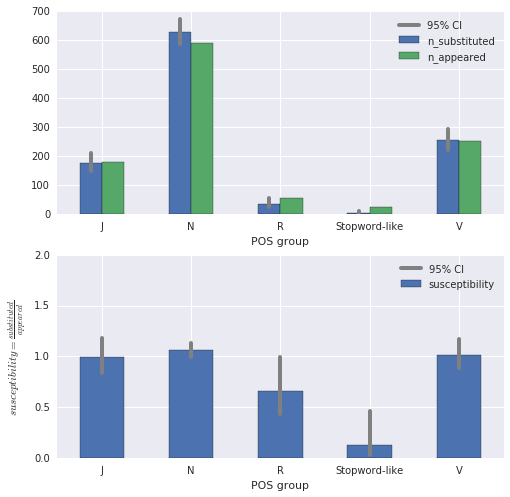

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


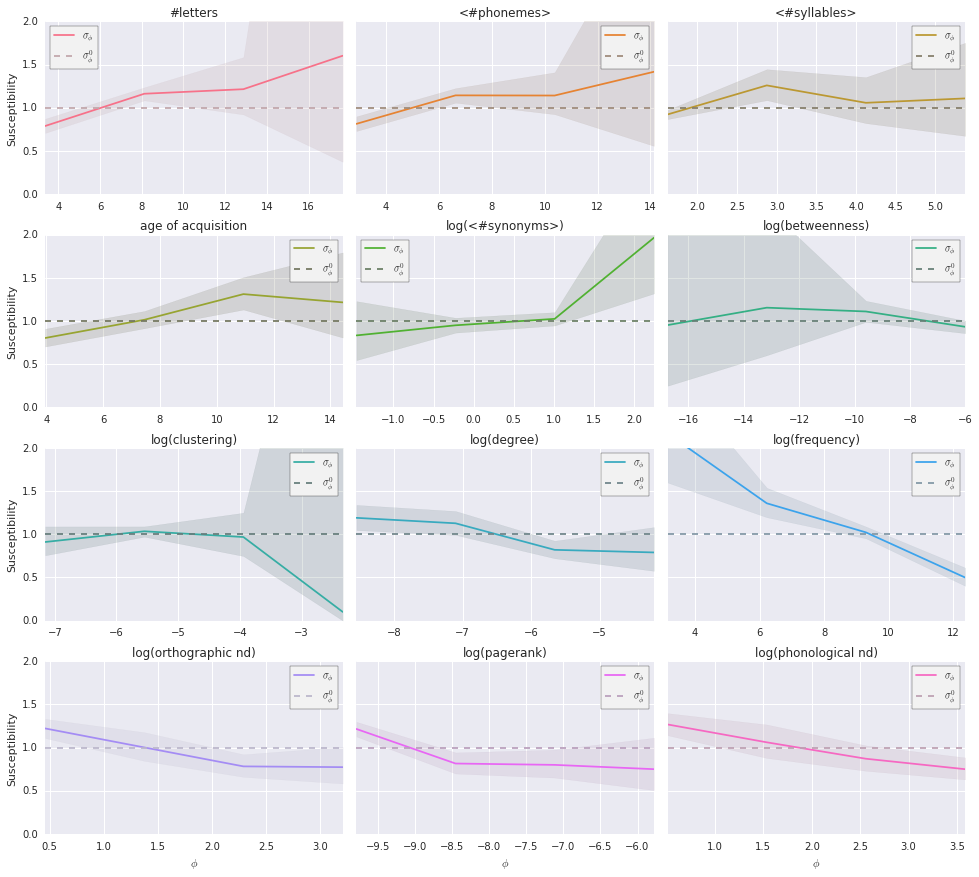

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
     Target NOT different from H_0 (p > 0.001)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


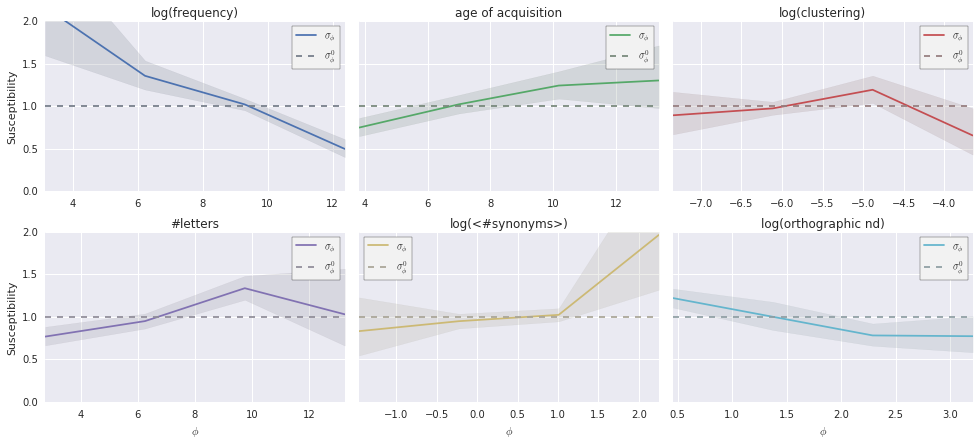

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


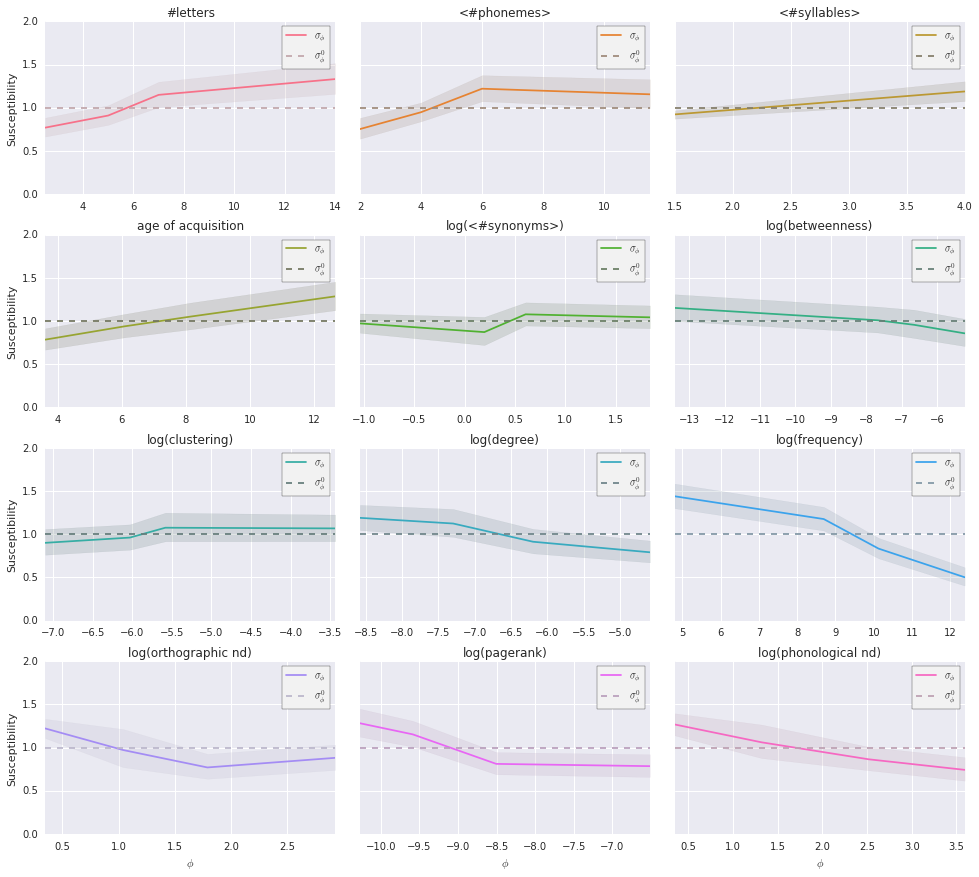

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


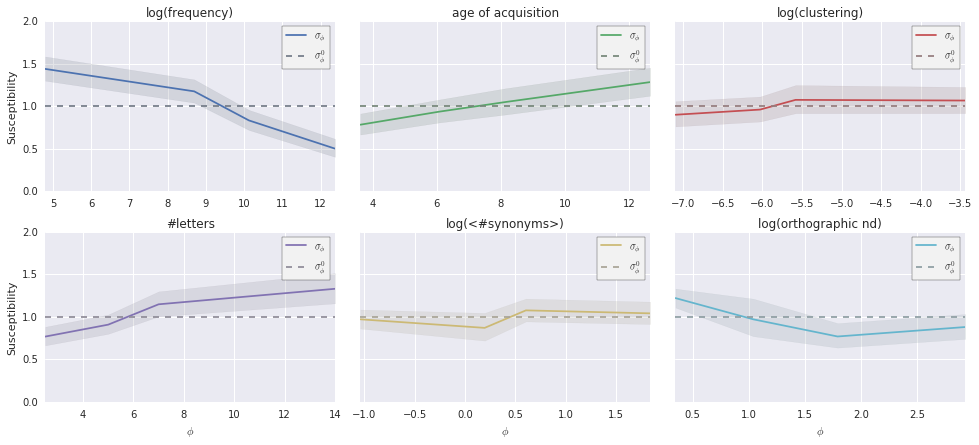

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


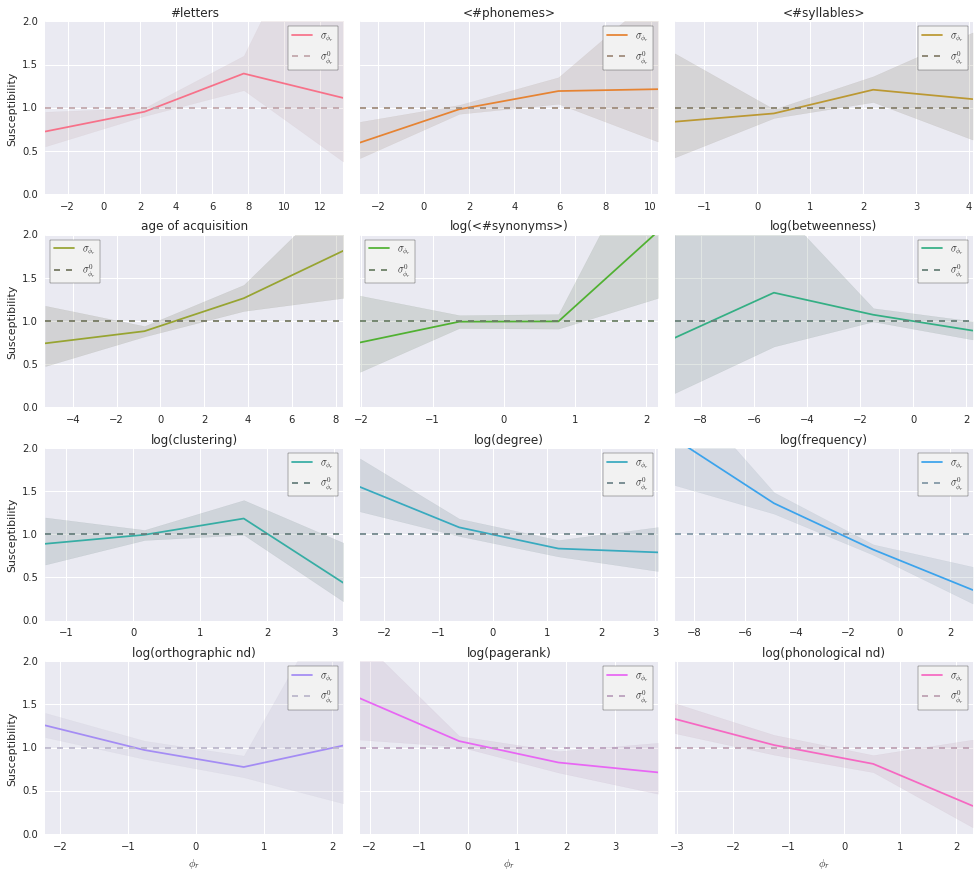

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


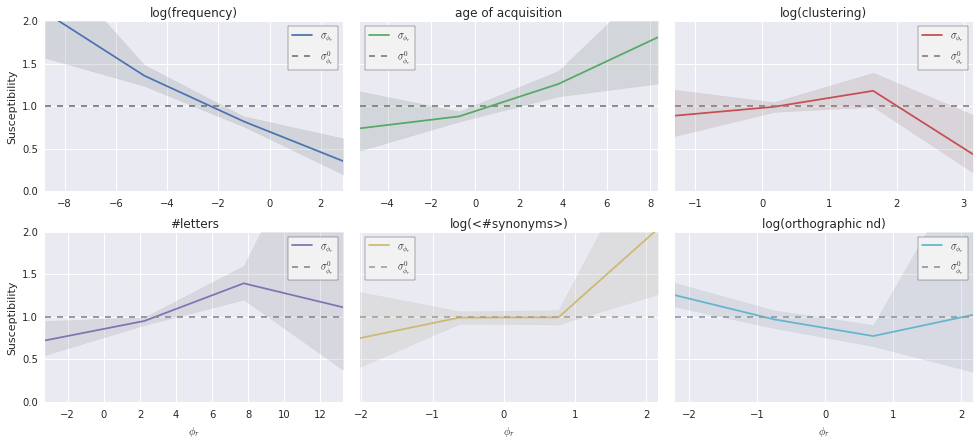

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


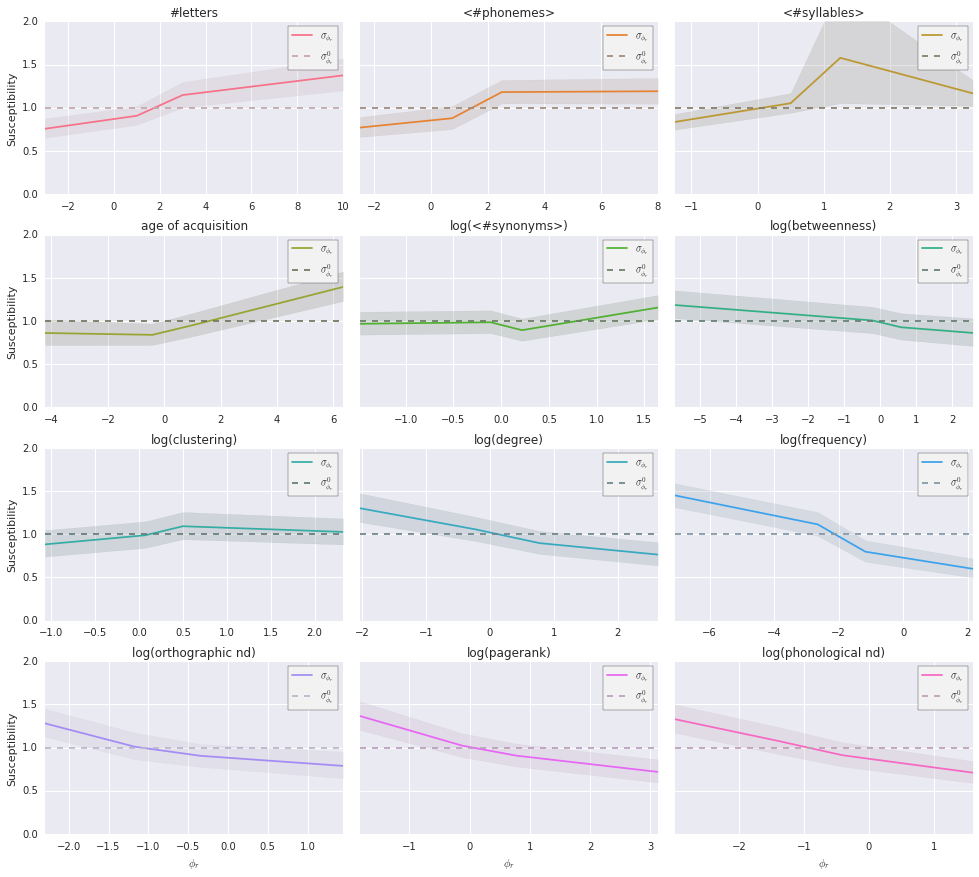

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]


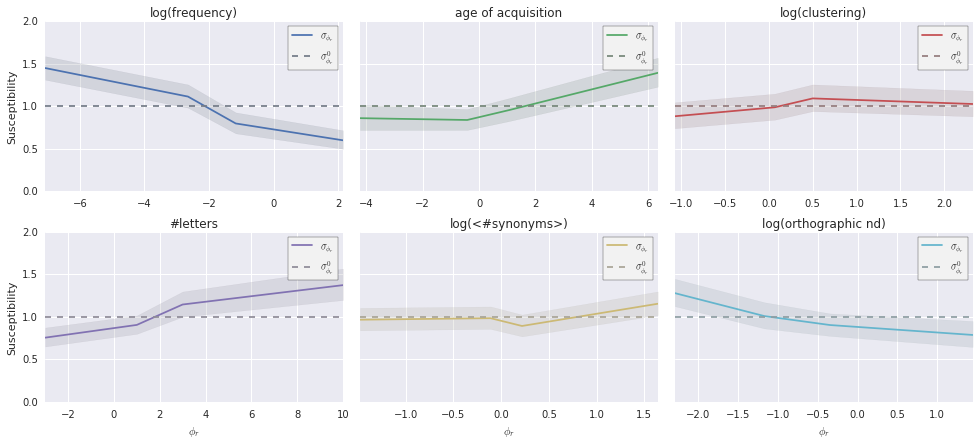

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


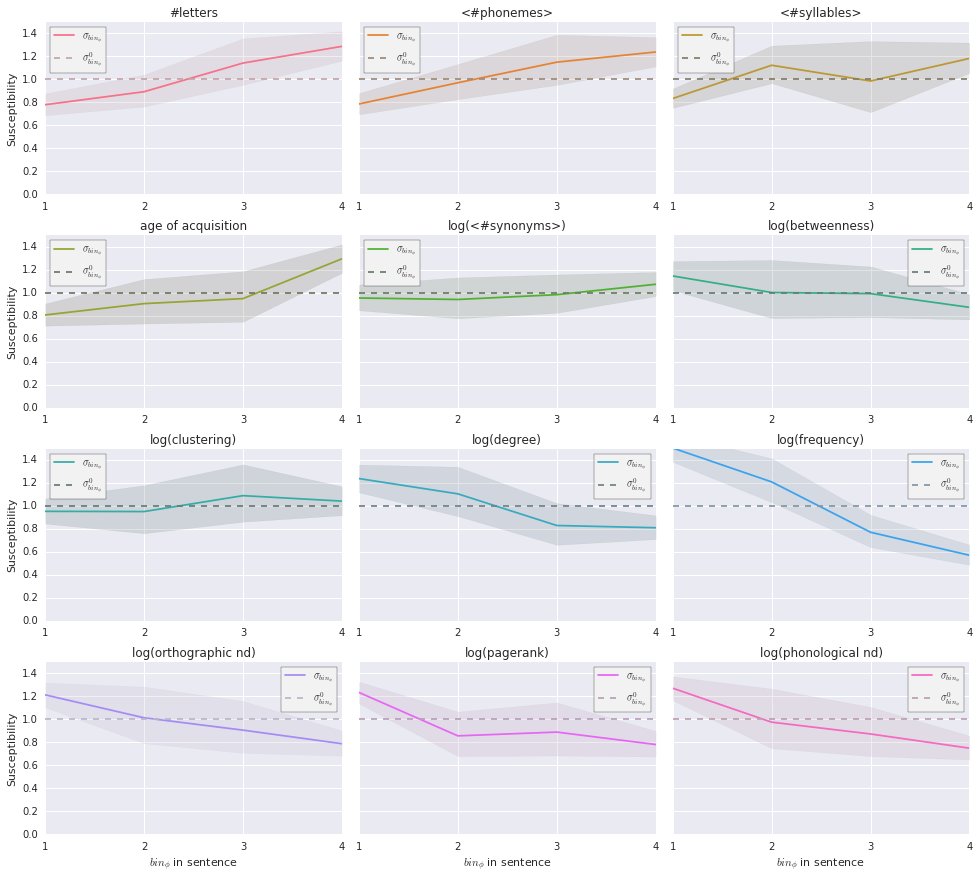

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


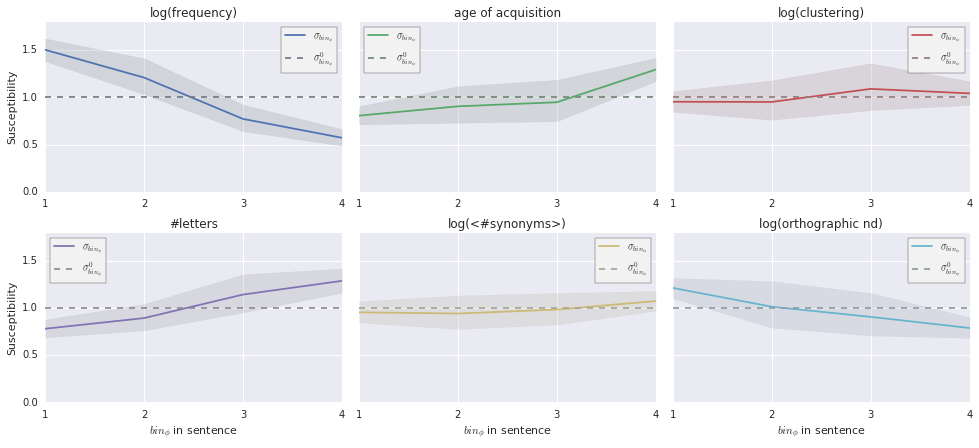

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


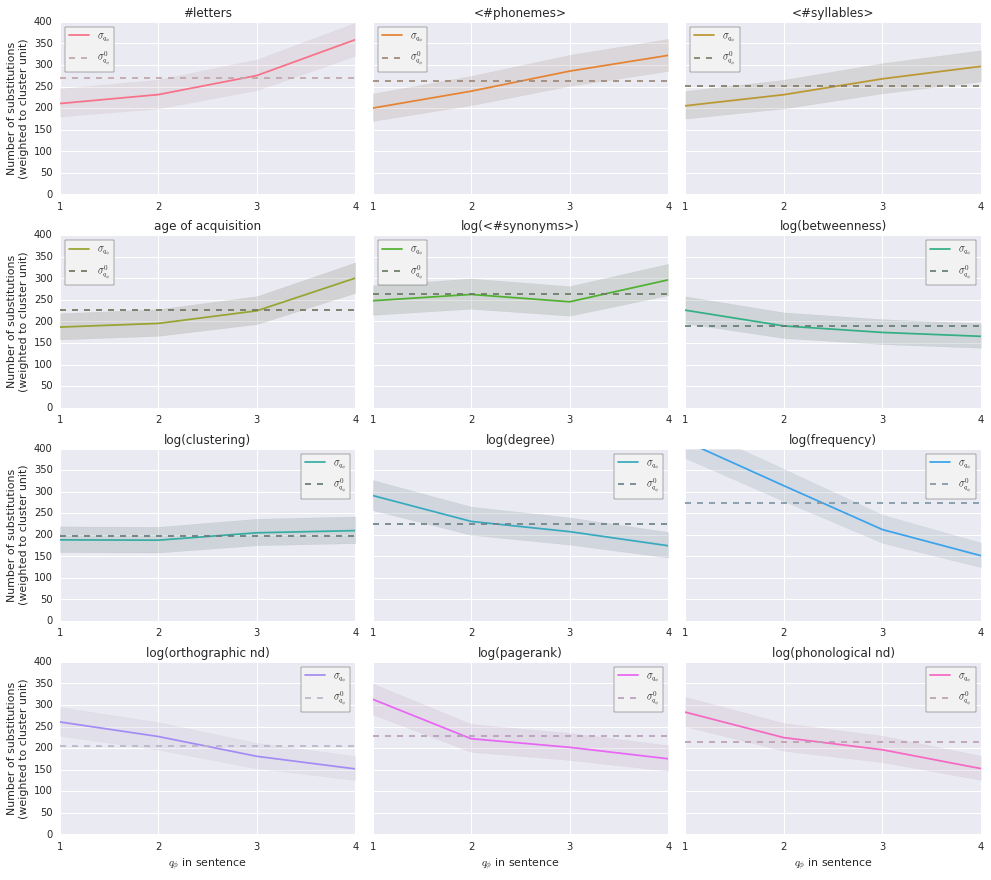

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


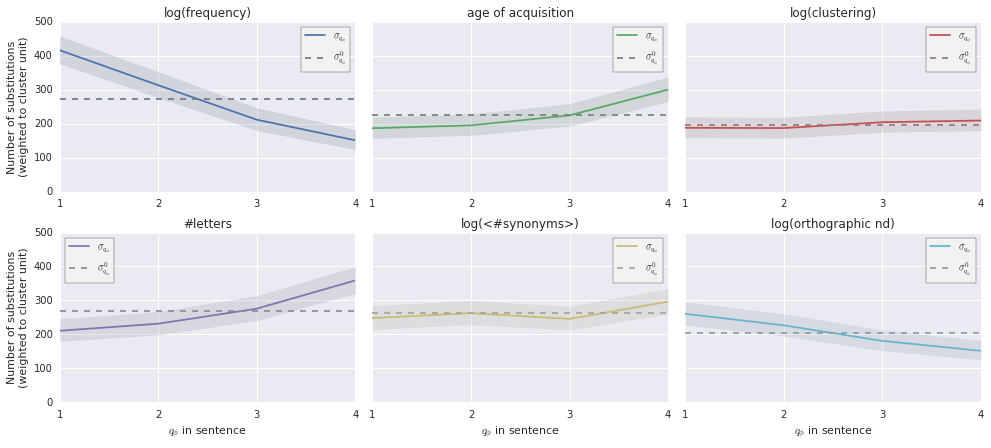

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 115820 word measures (divided into training and prediction sets)



57.00% of words well predicted (non-random at p = 7e-250)
Precision = 0.29
Recall = 0.59

Coefficients:


intercept                                             0.952216
global_frequency                                     -0.370181
global_aoa                                            0.028141
global_letters_count                                  0.283408
global_orthographic_density                           0.469218
global_frequency * global_aoa                         0.034661
global_frequency * global_letters_count              -0.017725
global_frequency * global_orthographic_density        0.017509
global_aoa * global_letters_count                    -0.022848
global_aoa * global_orthographic_density             -0.116574
global_letters_count * global_orthographic_density    0.071683
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 115820 word measures (divided into training and prediction sets)



54.54% of words well predicted (non-random at p = 4e-106)
Precision = 0.24
Recall = 0.47

Coefficients:
intercept                                                        -0.409059
sentence-rel_frequency                                           -0.174073
sentence-rel_aoa                                                 -0.092111
sentence-rel_letters_count                                        0.039794
sentence-rel_orthographic_density                                -0.038924
sentence-rel_frequency * sentence-rel_aoa                        -0.001499
sentence-rel_frequency * sentence-rel_letters_count              -0.005513
sentence-rel_frequency * sentence-rel_orthographic_density        0.015308
sentence-rel_aoa * sentence-rel_letters_count                     0.031487
sentence-rel_aoa * sentence-rel_orthographic_density             -0.018373
sentence-rel_letters_count * sentence-rel_orthographic_density    0.071544
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 115820 word measures (divided into training and prediction sets)



61.64% of words well predicted (non-random at p = 5e-324)
Precision = 0.33
Recall = 0.62

Coefficients:
intercept                                                         -2.102936
sentence-rel_frequency                                            -0.610016
sentence-rel_aoa                                                   0.240728
sentence-rel_letters_count                                         0.191862
sentence-rel_orthographic_density                                  1.466282
global_frequency                                                   0.024685
global_aoa                                                        -0.592228
global_letters_count                                               1.116578
global_orthographic_density                                        1.125615
sentence-rel_frequency * sentence-rel_aoa                         -0.011965
sentence-rel_frequency * sentence-rel_letters_count               -0.040856
sentence-rel_frequency * sentence-rel_orthographic_density 

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 115820 word measures (divided into training and prediction sets)



49.04% of words well predicted (non-random at p = 4e-06)
Precision = 0.29
Recall = 0.83

Coefficients:
intercept                                                       0.205233
bins-global_frequency                                           1.443463
bins-global_aoa                                                -0.215310
bins-global_letters_count                                      -1.294499
bins-global_orthographic_density                                0.253155
bins-global_frequency * bins-global_aoa                         0.113210
bins-global_frequency * bins-global_letters_count              -0.523004
bins-global_frequency * bins-global_orthographic_density       -0.704685
bins-global_aoa * bins-global_letters_count                     0.372810
bins-global_aoa * bins-global_orthographic_density             -0.336837
bins-global_letters_count * bins-global_orthographic_density    0.983766
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 115820 word measures (divided into training and prediction sets)



62.42% of words well predicted (non-random at p = 5e-324)
Precision = 0.24
Recall = 0.30

Coefficients:
intercept                                                                 1.193037
quantiles-global_frequency                                               -3.452417
quantiles-global_aoa                                                     -0.775780
quantiles-global_letters_count                                            5.905159
quantiles-global_orthographic_density                                    -1.313295
quantiles-global_frequency * quantiles-global_aoa                         1.340045
quantiles-global_frequency * quantiles-global_letters_count              -1.029853
quantiles-global_frequency * quantiles-global_orthographic_density        1.197567
quantiles-global_aoa * quantiles-global_letters_count                    -0.957352
quantiles-global_aoa * quantiles-global_orthographic_density             -0.615909
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 115820 word measures (divided into training and prediction sets)



67.59% of words well predicted (non-random at p = 5e-324)
Precision = 0.30
Recall = 0.30

Coefficients:
intercept                                                                   1.283273
bins-sentence-rel_frequency                                                -0.731078
bins-sentence-rel_aoa                                                      -0.630921
bins-sentence-rel_letters_count                                            -0.688938
bins-sentence-rel_orthographic_density                                      1.283273
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.037649
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.509984
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.731078
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.903911
bins-sentence-rel_aoa * bins-sentence-rel_orthographic_density             -0.630921
bins-sentence-rel_letters_count * bins-senten

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 115820 word measures (divided into training and prediction sets)



50.46% of words well predicted (non-random at p = 0.03)
Precision = 0.28
Recall = 0.73

Coefficients:
intercept                                                                             0.325586
quantiles-sentence-rel_frequency                                                     -0.406966
quantiles-sentence-rel_aoa                                                           -0.285634
quantiles-sentence-rel_letters_count                                                 -0.100421
quantiles-sentence-rel_orthographic_density                                          -0.022735
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.158204
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.104953
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.169950
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters_count                     0.124357
quantiles-sentence-rel_aoa * quantiles-sen

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 115820 word measures (divided into training and prediction sets)



63.50% of words well predicted (non-random at p = 5e-324)
Precision = 0.34
Recall = 0.60

Coefficients:
intercept                                                                -0.480027
in-sentence-bins_frequency                                               -0.104696
in-sentence-bins_aoa                                                      0.324378
in-sentence-bins_letters_count                                            0.191990
in-sentence-bins_orthographic_density                                     0.316651
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.046459
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.102190
in-sentence-bins_frequency * in-sentence-bins_orthographic_density       -0.026957
in-sentence-bins_aoa * in-sentence-bins_letters_count                    -0.012272
in-sentence-bins_aoa * in-sentence-bins_orthographic_density             -0.092236
in-sentence-bins_letters_count * in-sentence-bins_orthographic_de

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 896 aggregated word measures



Variance explained by first 2 components (mle-estimated): [ 0.66300791  0.20027519]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.373213  0.545400
aoa            0.753916 -0.293143
letters_count  0.540668  0.785243


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 896 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.625933    0.20945661]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.507655  0.442792
aoa            0.698637 -0.290422
letters_count  0.504175  0.848287
